# Transient CSEM for a layered, marine model

### `emg3d` and `empymod`

Shallow marine setting; comparison of semi-analytical computation with `empymod` and frequency-domain computation followed by a Fourier transform with `emg3d`.

In [1]:
import emg3d
import empymod
import discretize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Name is used to store the data for each frequency.
name = '1D-Model'

In [2]:
%matplotlib notebook

## Model and Survey

In [3]:
src = [0, 0, -180]
rec = [np.array([3000, 5000, 7000]), np.zeros(3), -200]
res = np.array([1e10, 1/3, 1, 50, 1])
depth = np.array([0, -200, -2200, -2300])

Here we create a dummy mesh with one cell in x- and y-directions, and our 1D model in z-direction. From this, we can interpolate the model to our varying meshes afterwards.

<IPython.core.display.Javascript object>


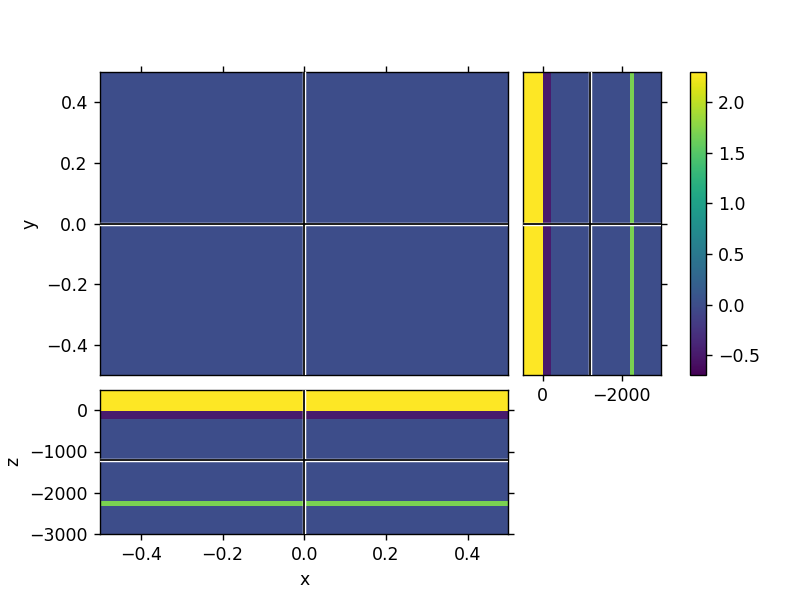

In [4]:
# Create the mesh.
orig_mesh = discretize.TensorMesh(
    [[1,], [1,], np.r_[1000, -np.diff(depth)[::-1], 1000]],
    x0=('C', 'C', depth[-1]-1000))

# Create a resistivity model using the 1D model and the above mesh.
orig_model = emg3d.utils.Model(orig_mesh, res_x=np.array(res)[::-1])

# QC.
orig_mesh.plot_3d_slicer(np.log10(orig_model.res_x), zlim=[-3000, 500], clim=np.log10([0.2, 200]))

## Fourier Transform parameters

We only compute frequencies $0.007 < f < 32$ Hz, which yields enough precision for our purpose.

This means, instead of 35 frequencies from 0.00002 - 126 Hz, we only need 19 frequencies from 0.008 - 32 Hz.

In [5]:
# Define desired times.
time = np.logspace(-2, 2, 301)

# Initiate a Fourier instance
Fourier = emg3d.utils.Fourier(
    time=time,
    fmin=0.007,
    fmax=32,
    ft='fftlog',  # Fourier transform to use
    ftarg={'pts_per_dec': 5, 'add_dec': [-2, 1], 'q': 0},
)

# Dense frequencies for comparison reasons
freq_dense = np.logspace(np.log10(Fourier.freq_req.min()/2), np.log10(Fourier.freq_req.max()*2), 301)

   time        [s] :  0.01 - 100 : 301  [min-max; #]
   Fourier         :  FFTLog
     > pts_per_dec :  5
     > add_dec     :  [-2.  1.]
     > q           :  0.0
   Req. freq  [Hz] :  2.00364E-05 - 126.421 : 35  [min-max; #]
   Calc. freq [Hz] :  0.00797664 - 31.7556 : 19  [min-max; #]


## Frequency-domain computation

In [6]:
# To store the info of each frequency.
values = {}

gridinput = {
    'min_width': 100,     # Fix the cell width within the survey domain to 100 m.
    'return_info': True,  # To get back some information for later.
    'max_domain': 50000,
    'verb': 0,
}

# Start the timer.
runtime = emg3d.utils.Time()

# Loop over frequencies, going from high to low.
for fi, frq in enumerate(Fourier.freq_calc[::-1]):
    print(f"  {fi+1:2}/{Fourier.freq_calc.size} :: {frq:10.6f} Hz; #cells: ", end='')
    
    # Key is used to store the data etc.
    key = int(frq*1e6)
          
    # Initiate log for this frequency.
    values[key] = {}
    values[key]['freq'] = frq

    # Get cell widths and origin in each direction
    xx, x0, hix = emg3d.utils.get_hx_h0(
        freq=frq, res=[0.3, 1e5], fixed=src[0], domain=[-100, 7100], **gridinput)
    yy, y0, hiy = emg3d.utils.get_hx_h0(
        freq=frq, res=[0.3, 1e5], fixed=src[1], domain=[-400, 400], **gridinput)
    zz, z0, hiz = emg3d.utils.get_hx_h0(
        freq=frq, res=[0.3, 1., 1e5], domain=[-2300, 0], **gridinput,
        fixed=[depth[1], depth[0], depth[-1]])
    
    # Store values in log.
    values[key]['alpha'] = [np.min([hix['amin'], hiy['amin'], hiz['amin']]),
                            np.max([hix['amax'], hiy['amax'], hiz['amax']])]
    values[key]['dminmax'] = [np.min([hix['dmin'], hiy['dmin'], hiz['dmin']]),
                              np.max([hix['dmax'], hiy['dmax'], hiz['dmax']])]

    # Initiate mesh.
    grid = discretize.TensorMesh([xx, yy, zz], x0=np.array([x0, y0, z0]))
    print(grid.nC)
    values[key]['nC'] = grid.nC  # Store number of cells in log.

    # Generate model (interpolate on log-scale from our coarse model).
    res_x = emg3d.utils.grid2grid(orig_mesh, orig_model.res_x, grid, 'volume', log=True)
    model = emg3d.utils.Model(grid, res_x)
    # grid.plot_3d_slicer(np.log10(model.res_x), zlim=[-3000, 500], clim=np.log10([0.2, 200]))  # QC

    # Define source.
    sfield = emg3d.utils.get_source_field(
        grid, [src[0], src[1], src[2], 0, 0], frq, strength=0)

    # Solve the system.
    efield, info = emg3d.solve(
        grid, model, sfield, verb=-1, return_info=True,
        sslsolver=True,  semicoarsening=True, linerelaxation=True,
    )

    # Store info
    values[key]['info'] = info
    
    # Store value
    values[key]['data'] = emg3d.utils.get_receiver(grid, efield.fx, (rec[0], rec[1], rec[2]))

# Stop the timer.
total_time = runtime.runtime

# Store data and info to disk
# emg3d.save('../data/'+name+'.h5', values=values)

   1/19 ::  31.755586 Hz; #cells: 204800
:: emg3d :: 1.3e-07; 1(3); 0:00:10; CONVERGED
   2/19 ::  20.036420 Hz; #cells: 204800
:: emg3d :: 3.7e-07; 1(3); 0:00:09; CONVERGED
   3/19 ::  12.642126 Hz; #cells: 204800
:: emg3d :: 9.9e-07; 1(3); 0:00:09; CONVERGED
   4/19 ::   7.976643 Hz; #cells: 204800
:: emg3d :: 5.8e-07; 1(5); 0:00:17; CONVERGED
   5/19 ::   5.032921 Hz; #cells: 204800
:: emg3d :: 5.5e-08; 1(6); 0:00:21; CONVERGED
   6/19 ::   3.175559 Hz; #cells: 204800
:: emg3d :: 1.3e-07; 1(6); 0:00:20; CONVERGED
   7/19 ::   2.003642 Hz; #cells: 204800
:: emg3d :: 2.6e-07; 1(6); 0:00:18; CONVERGED
   8/19 ::   1.264213 Hz; #cells: 245760
:: emg3d :: 5.7e-07; 1(6); 0:00:22; CONVERGED
   9/19 ::   0.797664 Hz; #cells: 245760
:: emg3d :: 6.6e-07; 2(7); 0:00:26; CONVERGED
  10/19 ::   0.503292 Hz; #cells: 245760
:: emg3d :: 9.9e-07; 2(8); 0:00:29; CONVERGED
  11/19 ::   0.317556 Hz; #cells: 245760
:: emg3d :: 2.8e-07; 2(11); 0:00:42; CONVERGED
  12/19 ::   0.200364 Hz; #cells: 245760
:

In [7]:
# Load info and data
values = emg3d.load('../data/'+name+'.h5')['Data']['values']

runtime = 0
for frq in Fourier.freq_calc[::-1]:
    key = int(frq*1e6)
    value = values[str(key)]
    print(f"  {value['freq']:7.3f} Hz: {value['info']['it_mg']:2g}/{value['info']['it_ssl']:g} it; "
          f"{value['info']['time']:4.0f} s; "
          f"a: {value['alpha'][0]:.3f} / {value['alpha'][1]:.3f} ; "
          f"nC: {value['nC']:8,.0f}; "
          f"a: {value['dminmax'][0]:5.0f} / {value['dminmax'][1]:7.0f}")
    runtime += value['info']['time']
    
print(f"\n                **** TOTAL RUNTIME :: {runtime//60:.0f} min {runtime%60:.1f} s ****\n")

  Loaded file /home/dtr/Codes/article-TDEM/data/1D-Model.h5
  -> Stored with emg3d v0.11.0 (format 0.10.0) on 2020-06-22T17:29:27.365150
   31.756 Hz:  3/1 it;   10 s; a: 1.000 / 1.360 ; nC:  204,800; a:   100 /   13697
   20.036 Hz:  3/1 it;    9 s; a: 1.000 / 1.360 ; nC:  204,800; a:   100 /   13697
   12.642 Hz:  3/1 it;    9 s; a: 1.000 / 1.360 ; nC:  204,800; a:   100 /   13697
    7.977 Hz:  5/1 it;   17 s; a: 1.000 / 1.360 ; nC:  204,800; a:   100 /   13697
    5.033 Hz:  6/1 it;   21 s; a: 1.000 / 1.440 ; nC:  204,800; a:   100 /   16484
    3.176 Hz:  6/1 it;   20 s; a: 1.000 / 1.480 ; nC:  204,800; a:   100 /   16346
    2.004 Hz:  6/1 it;   18 s; a: 1.000 / 1.490 ; nC:  204,800; a:   100 /   17841
    1.264 Hz:  6/1 it;   22 s; a: 1.000 / 1.360 ; nC:  245,760; a:   100 /   13697
    0.798 Hz:  7/2 it;   26 s; a: 1.000 / 1.360 ; nC:  245,760; a:   100 /   16956
    0.503 Hz:  8/2 it;   29 s; a: 1.000 / 1.360 ; nC:  245,760; a:   100 /   13697
    0.318 Hz: 11/2 it;   42 s; a:

### Load data, interpolate at receiver location

In [8]:
# Initiate data with zeros.
data = np.zeros((Fourier.freq_calc.size, rec[0].size), dtype=complex)

# Loop over frequencies.
for fi, frq in enumerate(Fourier.freq_calc):
    key = int(frq*1e6)
    data[fi, :] = values[str(key)]['data']

### Interpolate missing frequencies and compute analytical result

In [9]:
data_int = np.zeros((Fourier.freq_req.size, rec[0].size), dtype=complex)

for fi in range(rec[0].size):
    data_int[:, fi] = Fourier.interpolate(data[:, fi])

# Compute analytical result using empymod
epm_req = empymod.dipole(src, rec, depth, res, Fourier.freq_req, verb=1)
epm_calc = empymod.dipole(src, rec, depth, res, Fourier.freq_calc, verb=1)
epm_dense = empymod.dipole(src, rec, depth, res, freq_dense, verb=1)

# Compute error
err =  np.clip(100*abs((data_int.imag-epm_req.imag)/epm_req.imag), 0.1, 100)

## Fourier Transform

Carry-out Fourier transform, compute analytical result

In [10]:
data_time = np.zeros((Fourier.time.size, rec[0].size))

# Compute corresponding time-domain signal.
for fi in range(rec[0].size):
    data_time[:, fi] = Fourier.freq2time(data[:, fi], rec[0][fi])

# Analytical result
epm_time = empymod.dipole(src, rec, depth, res, time, signal=0, verb=1)

# Relative error and peak error
err_egd = np.clip(100*abs((data_time-epm_time)/epm_time), 0.1, 100)

### Plot it

<IPython.core.display.Javascript object>


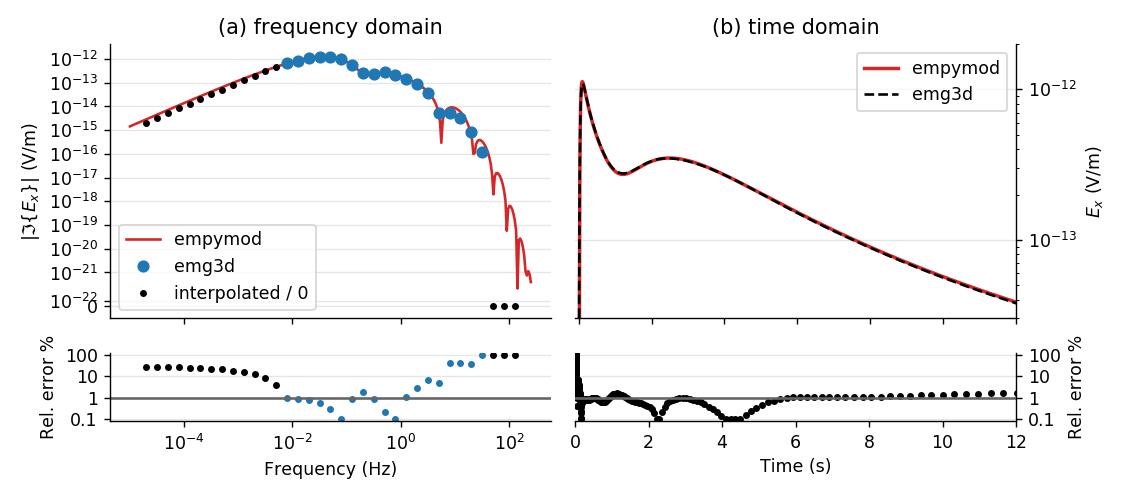

In [11]:
plt.figure(figsize=(9, 4))

ii = 1

# Imaginary, log-symlog
ax1 = plt.subplot2grid((4, 2), (0, 0), rowspan=3)
plt.title('(a) frequency domain')
plt.plot(freq_dense, abs(epm_dense[:, ii].imag), 'C3', label='empymod')
plt.plot(Fourier.freq_calc, abs(data[:, ii].imag), 'C0o', label='emg3d')
plt.plot(Fourier.freq_req[~Fourier.freq_calc_i],
         abs(data_int[~Fourier.freq_calc_i, ii].imag), 'k.', label='interpolated / 0')
plt.ylabel('$|\Im\{E_x\}|$ (V/m)')
plt.xscale('log')
#plt.xlim([0.00001, 22])
plt.yscale('symlog', linthreshy=5e-22)
ax1.set_xticklabels([])
plt.legend()
plt.grid(axis='y', c='0.9')

# Imaginary, error
ax2 = plt.subplot2grid((4, 2), (3, 0))
plt.plot(Fourier.freq_req[~Fourier.freq_calc_i], err[~Fourier.freq_calc_i, ii], 'k.')
plt.plot(Fourier.freq_calc, err[Fourier.freq_calc_i, ii], 'C0.')
plt.axhline(1, color='.4')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Rel. error %')
plt.xlim(ax1.get_xlim())
plt.ylim([8e-2, 120])
plt.yticks([0.1, 1, 10, 100], ('0.1', '1', '10', '100'))
plt.grid(axis='y', c='0.9')


# Time domain
ax3 = plt.subplot2grid((4, 2), (0, 1), rowspan=3)
plt.title('(b) time domain')
plt.plot(time, epm_time[:, ii], 'C3', lw=2, label='empymod')
plt.plot(time, data_time[:, ii], 'k--', label='emg3d')
plt.xlim([-0.1, 12])
plt.ylim([3e-14, 2e-12])
plt.ylabel('$E_x$ (V/m)')
#plt.xscale('log')
plt.yscale('log')
ax3.set_xticklabels([])
plt.legend()
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
plt.grid(axis='y', c='0.9')

# Time domain, error
ax4 = plt.subplot2grid((4, 2), (3, 1))
plt.plot(time, err_egd[:, ii], 'k.')
plt.axhline(1, color='.4')

plt.yscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Rel. error %')
plt.xlim([0, 12])
plt.ylim([8e-2, 120])
plt.yticks([0.1, 1, 10, 100], ('0.1', '1', '10', '100'))
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
plt.grid(axis='y', c='0.9')

# Switch off spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)

plt.tight_layout()

#plt.savefig('../figures/marine.pdf', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


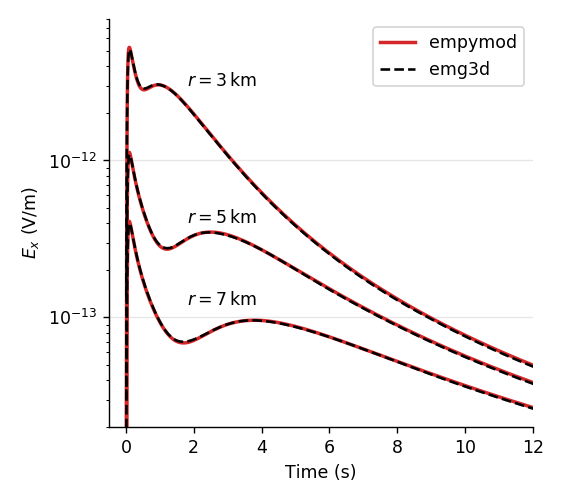

In [12]:
plt.figure(figsize=(4.5, 4))
ax = plt.gca()

# Time domain
lines = plt.plot(time, epm_time, 'C3', lw=2, label='empymod')
plt.setp(lines[1:], label="_")
lines = plt.plot(time, data_time, 'k--', label='emg3d')
lines = plt.setp(lines[1:], label="_")
plt.xlim([-0.5, 12])
plt.ylim([2e-14, 8e-12])
plt.ylabel('$E_x$ (V/m)')
plt.yscale('log')
plt.xlabel('Time (s)')
plt.legend()
plt.text(1.8, 3e-12, f"$r={rec[0][0]/1000:1.0f}\,$km")
plt.text(1.8, 4e-13, f"$r={rec[0][1]/1000:1.0f}\,$km")
plt.text(1.8, 1.2e-13, f"$r={rec[0][2]/1000:1.0f}\,$km")

plt.grid(axis='y', c='0.9')

# Switch off spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
#plt.savefig('../figures/marine-multioffset.pdf', bbox_inches='tight')
plt.show()

In [13]:
emg3d.Report([empymod, discretize])

--------------------------------------------------------------------------------
  Date: Mon Jun 22 17:23:48 2020 CEST

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
       Environment : Jupyter

  Python 3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:43:00)
  [GCC 7.5.0]

           empymod : 2.0.1
        discretize : 0.4.12
             numpy : 1.18.5
             scipy : 1.4.1
             numba : 0.48.0
             emg3d : 0.11.0
           IPython : 7.15.0
        matplotlib : 3.2.2
--------------------------------------------------------------------------------